### UFO Predictions
#### Angel, Filis

#### 1. First, import the following libraries

In [195]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

#### 2. Connect to the database called ufo.db which was made from a csv file which was made from scraping the site:  http://www.nuforc.org/index.html

In [236]:
conn = sqlite3.connect('/Users/filis/flatiron2019/UFO_proj_2/ufo.db')

In [237]:
c = conn.cursor()

#### 3. Grab all the data from the database ufo and save it as a dataframe table. 

In [242]:
c.execute('''select * from population''')
population_df = pd.DataFrame(c.fetchall())
population_df.columns = [i[0] for i in c.description]

In [243]:
population_df

,Geographic Area,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,AL,"4,785,448","4,798,834","4,815,564","4,830,460","4,842,481","4,853,160","4,864,745","4,875,120","4,887,871"
1,AK,"713,906","722,038","730,399","737,045","736,307","737,547","741,504","739,786","737,438"
2,AZ,"6,407,774","6,473,497","6,556,629","6,634,999","6,733,840","6,833,596","6,945,452","7,048,876","7,171,646"
3,AR,"2,921,978","2,940,407","2,952,109","2,959,549","2,967,726","2,978,407","2,990,410","3,002,997","3,013,825"
4,CA,"37,320,903","37,641,823","37,960,782","38,280,824","38,625,139","38,953,142","39,209,127","39,399,349","39,557,045"
5,CO,"5,048,281","5,121,771","5,193,721","5,270,482","5,351,218","5,452,107","5,540,921","5,615,902","5,695,564"
6,CT,"3,579,125","3,588,023","3,594,395","3,594,915","3,594,783","3,587,509","3,578,674","3,573,880","3,572,665"
7,DE,"899,595","907,316","915,188","923,638","932,596","941,413","949,216","957,078","967,171"
8,DC,"605,085","619,602","634,725","650,431","662,513","675,254","686,575","695,691","702,455"
9,FL,"18,845,785","19,093,352","19,326,230","19,563,166","19,860,330","20,224,249","20,629,982","20,976,812","21,299,325"


In [199]:
ufo_df = pd.DataFrame(c.fetchall())

In [200]:
ufo_df.columns = [i[0] for i in c.description]

#### 4. Display the data from the database as a dataframe.

In [201]:
ufo_df.Duration_sec=ufo_df.Duration_sec.astype(float)
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87749 entries, 0 to 87748
Data columns (total 8 columns):
City            87749 non-null object
State           87749 non-null object
Shape           87749 non-null object
Duration        87749 non-null object
Summary         87749 non-null object
Date_Posted     87749 non-null object
Duration_sec    87749 non-null float64
event_date      87749 non-null object
dtypes: float64(1), object(7)
memory usage: 5.4+ MB


In [202]:
ufo_df

,City,State,Shape,Duration,Summary,Date_Posted,Duration_sec,event_date
0,Cincinnati,OH,triangle,15 seconds,Large V/triangle-shaped craft that moved silen...,5/9/19,15.0,2019-05-09 21:15:00
1,Statesboro,GA,triangle,20 seconds,"Two UFO's near Statesboro, Ga. 11:00 PM 5-9-2019.",5/9/19,20.0,2019-05-08 23:00:00
2,Norfolk,VA,light,>10 minutes,"Extremely loud bang, light spotted in sky.",5/9/19,600.0,2019-05-08 23:00:00
3,Saint George,UT,other,1:30,Started noticing a huge flash of light @ aroun...,5/9/19,90.0,2019-05-08 01:30:00
4,Highlands,NC,light,1 minute,I have about 10 recordings from last night on ...,5/9/19,60.0,2019-05-08 01:00:00
5,Palm Coast,FL,sphere,6 minutes,05/07/19 I saw 2 spheres inside were white spa...,5/9/19,360.0,2019-05-07 22:00:00
6,Hobart,IN,other,15 seconds,"Absolutely still object, very large, hovering ...",5/9/19,15.0,2019-05-07 20:52:00
7,Seattle,WA,light,40 seconds,Ok so I'm just gonna say this happens often to...,5/9/19,40.0,2019-05-07 08:45:00
8,Walden,VT,triangle,15 minutes,Triangular Craft over Vermont. ((anonymous re...,5/9/19,900.0,2019-05-07 03:25:00
9,Regina (Canada),SK,light,3-4 minutes,Lights circling in the sky.,5/9/19,210.0,2019-05-06 22:45:00


#### 5. Data Exploration and Cleaning.

In [203]:
c.execute('''select * from ufo where state in ('DC','VA', 'MD') ''')
ufo_df_dc_metro = pd.DataFrame(c.fetchall())
ufo_df_dc_metro.columns = [i[0] for i in c.description]

In [204]:
# ufo_df_dc

In [205]:
c.execute('''select * from ufo where state= 'CA' ''')
ufo_df_ca = pd.DataFrame(c.fetchall())
ufo_df_ca.columns = [i[0] for i in c.description]

In [206]:
ufo_df.Duration_sec.isna().sum()

0

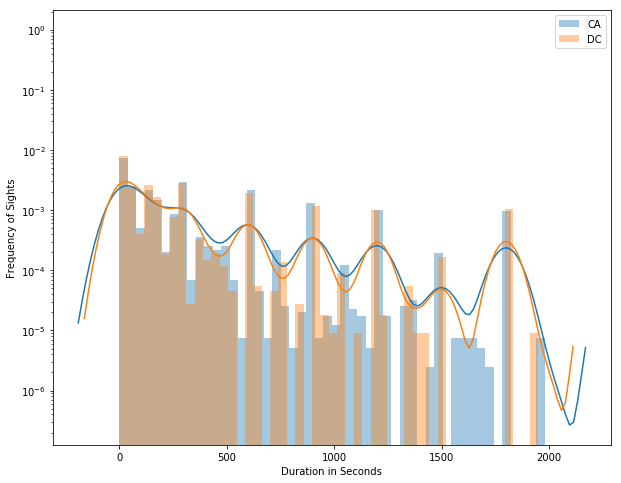

In [207]:
ufo_df_ca.Duration_sec=ufo_df_ca.Duration_sec.astype(float)
ufo_df_dc_metro.Duration_sec=ufo_df_dc_metro.Duration_sec.astype(float)
fig = plt.figure(figsize=(10,8))
sns.distplot(ufo_df_ca[ufo_df_ca.Duration_sec<2000]['Duration_sec'], bins=50, label='CA')
sns.distplot(ufo_df_dc_metro[ufo_df_dc_metro.Duration_sec<2000]['Duration_sec'], bins=50, label='DC')
plt.semilogy(True)
plt.ylabel('Frequency of Sights')
plt.xlabel('Duration in Seconds')
plt.legend()
# plt.xlim(0,20000)

In [208]:
ttest_ind(ufo_df_ca[ufo_df_ca.Duration_sec<2000]['Duration_sec'],
          ufo_df_dc_metro[ufo_df_dc_metro.Duration_sec<2000]['Duration_sec'] ,
          equal_var=False)


Ttest_indResult(statistic=2.014757015192087, pvalue=0.04399005572499871)

In [209]:
# The p-value is less than 0.05 so we reject the null hypothesis and there is a
# difference between the duration of sightings in CA vs DC. 

In [210]:
len(ufo_df_ca.Duration_sec<2000)

10832

In [211]:
len(ufo_df_dc.Duration_sec<2000)

2851

In [212]:
# ufo_df

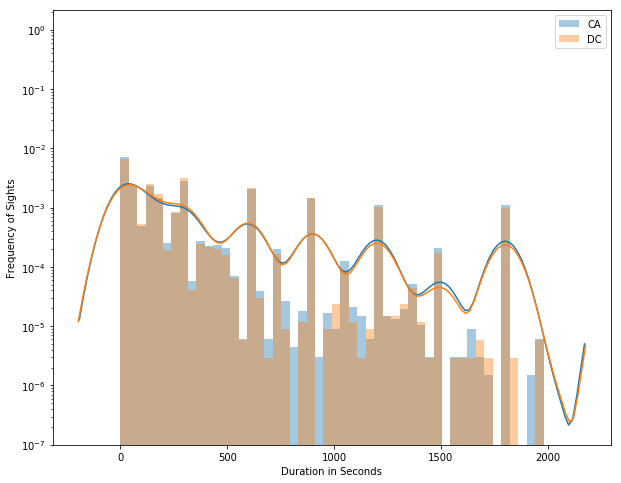

In [213]:
ufo_df.Duration_sec=ufo_df.Duration_sec.astype(float)
fig = plt.figure(figsize=(10,8))
sns.distplot(ufo_df[(ufo_df.Shape=='light')&(ufo_df.Duration_sec<2000)]['Duration_sec'], bins=50, label='CA')
sns.distplot(ufo_df[(ufo_df.Shape=='circle')&(ufo_df.Duration_sec<2000)]['Duration_sec'], bins=50, label='DC')
plt.semilogy(True)
plt.ylabel('Frequency of Sights')
plt.xlabel('Duration in Seconds')
plt.legend()

In [214]:
ttest_ind(ufo_df[(ufo_df.Shape=='light')&(ufo_df.Duration_sec<2000)]['Duration_sec'],
          ufo_df[(ufo_df.Shape=='circle')&(ufo_df.Duration_sec<2000)]['Duration_sec'] ,
          equal_var=False)

Ttest_indResult(statistic=1.7803820647429878, pvalue=0.07503052217034971)

In [215]:
ttest_ind(ufo_df[(ufo_df.Shape=='light')&(ufo_df.Duration_sec<100)]['Duration_sec'],
          ufo_df[(ufo_df.Shape=='circle')&(ufo_df.Duration_sec<100)]['Duration_sec'] ,
          equal_var=False)

Ttest_indResult(statistic=-1.3508729455918576, pvalue=0.17678421382982265)

In [216]:
ttest_ind(ufo_df[(ufo_df.Shape=='light')]['Duration_sec'],
          ufo_df[(ufo_df.Shape=='circle')]['Duration_sec'] ,
          equal_var=False)

Ttest_indResult(statistic=1.6334214701656156, pvalue=0.10239716334304953)

In [217]:
ttest_ind(ufo_df[(ufo_df.Shape=='light')&(ufo_df.Duration_sec<2000)]['Duration_sec'],
          ufo_df[(ufo_df.Shape=='sphere')&(ufo_df.Duration_sec<2000)]['Duration_sec'] ,
          equal_var=False)

Ttest_indResult(statistic=5.413330146045986, pvalue=6.319311001862668e-08)

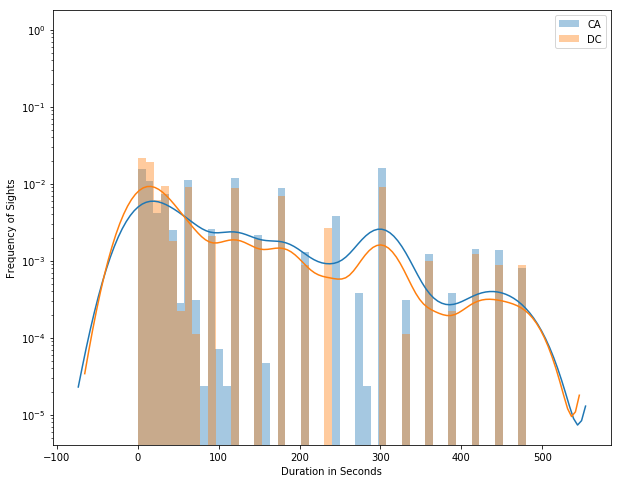

In [218]:
ufo_df.Duration_sec=ufo_df.Duration_sec.astype(float)
fig = plt.figure(figsize=(10,8))
sns.distplot(ufo_df[(ufo_df.Shape=='sphere')&(ufo_df.Duration_sec<500)]['Duration_sec'], bins=50, label='CA')
sns.distplot(ufo_df[(ufo_df.Shape=='chevron')&(ufo_df.Duration_sec<500)]['Duration_sec'], bins=50, label='DC')
plt.semilogy(True)
plt.ylabel('Frequency of Sights')
plt.xlabel('Duration in Seconds')
plt.legend()

In [219]:
ttest_ind(ufo_df[(ufo_df.Shape=='chevron')&(ufo_df.Duration_sec<500)]['Duration_sec'],
          ufo_df[(ufo_df.Shape=='sphere')&(ufo_df.Duration_sec<500)]['Duration_sec'] ,
          equal_var=False)

Ttest_indResult(statistic=-8.496145533749967, pvalue=4.8230321805741803e-17)

In [231]:
ufo_df.Shape.value_counts()

light         18650
circle         9361
triangle       8704
fireball       7284
sphere         6187
unknown        6074
other          5911
disk           5091
oval           3987
formation      2908
changing       2179
cigar          2177
flash          1567
rectangle      1543
cylinder       1424
diamond        1333
chevron        1159
teardrop        786
egg             778
cone            354
cross           277
delta             7
round             2
pyramid           1
flare             1
dome              1
triangular        1
crescent          1
changed           1
Name: Shape, dtype: int64

### Plan

We have two questions already. 

Next Steps: 
1. Fix 15_20 duration and military time. 
2. Find Census data for population for CA and DC metro area for specific years. (3rd question)
3. Create db of the census data. 
4. How do the ufo shapes compare between 1960s vs 2000s? Does a certain shape last longer in 1960s vs now? 
5. Is there a difference between the number of sightings per population for a specific region for specific year/decade? 

For DC metro and CA:

First Question: How does CA vs DC metro area differ in terms of number of durations? - bootstrap & ttest

1. From CA distribution, we pick 500 numbers randomly from those numbers we record the mean and the standard deviation. Repeat 1000 times. 

2. Plot a distribution plot of the means found in 1. This should look like a normal distribution. 

3. Repeat the same process for DC metro. 

4. Apply the t-test on the two new distributions. 

Second Question: How different are the durations between shapes? - (boot strap + ttest)

5. Choose two shapes and do 1-4 on those. This is the second question. 

6. Use CA group by year and count the number of events. 

Third Question: Number of sights per capital 




Bootstrap for states

In [220]:
ca_means = []
for i in range(1000):
    x_ca = np.random.choice(ufo_df_ca['Duration_sec'],size=500)
    ca_means.append(x_ca.mean())

In [221]:
dc_means = []
for i in range(1000):
    x_dc = np.random.choice(ufo_df_dc_metro['Duration_sec'],size=500)
    dc_means.append(x_dc.mean())

In [222]:
# ca_means

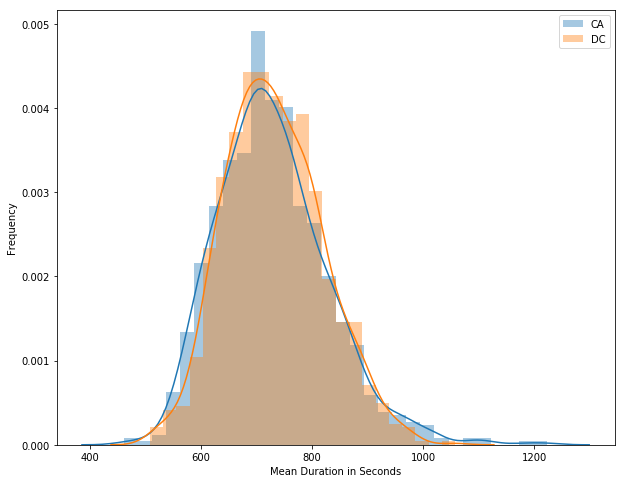

In [223]:
fig = plt.figure(figsize=(10,8))
sns.distplot(ca_means, label='CA')
sns.distplot(dc_means, label='DC')
plt.ylabel('Frequency')
plt.xlabel('Mean Duration in Seconds')
plt.legend()

In [229]:
ttest_ind(ca_means,
          dc_means ,
          equal_var=False)

Ttest_indResult(statistic=-0.652558283766884, pvalue=0.5141175277645815)

The duration between east and west coast is the same, we do not reject the null hypothesis which was they are the same. 

In [226]:
np.array(ca_means).std()

99.85648744239134

In [227]:
np.array(dc_means).std()

87.15949167884152

Checking out the shapes

In [232]:
circle_means = []
for i in range(1000):
    x_circle = np.random.choice(ufo_df[ufo_df.Shape=='circle']['Duration_sec'],size=500)
    circle_means.append(x_circle.mean())

In [233]:
triangle_means = []
for i in range(1000):
    x_triangle = np.random.choice(ufo_df[ufo_df.Shape=='triangle']['Duration_sec'],size=500)
    triangle_means.append(x_triangle.mean())

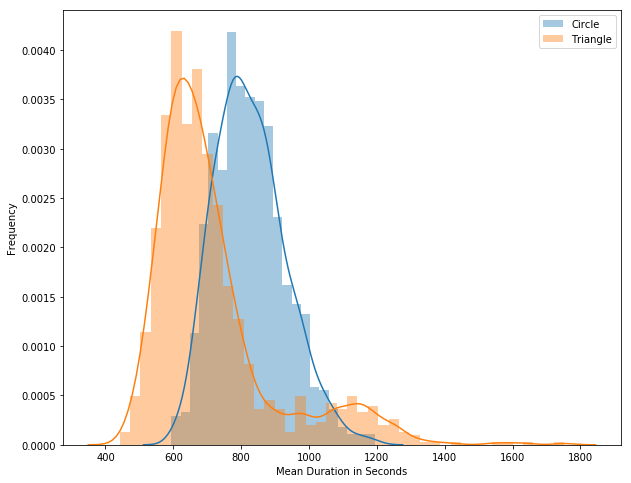

In [234]:
fig = plt.figure(figsize=(10,8))
sns.distplot(circle_means, label='Circle')
sns.distplot(triangle_means, label='Triangle')
plt.ylabel('Frequency')
plt.xlabel('Mean Duration in Seconds')
plt.legend()

In [235]:
ttest_ind(circle_means,
          triangle_means ,
          equal_var=False)

Ttest_indResult(statistic=16.33045848728626, pvalue=1.6201666229180797e-55)

The null hypothesis was that people see them the same amount of time, but in this case people see circles longer. 